# Assignment (Machine Learning) [40%]
**<u>Goals:</u>**
The aim of this project is to classify and predict the survival rate of patients with breast cancer. The models that we employed are XGBoost, Neural Network and ..

# 1.0 Project Preparation
## 1.1 Load Libraries

In [85]:
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
from pandas import set_option
from pandas import DataFrame

from xgboost import XGBClassifier
import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier

from pickle import dump

import scipy.stats as stats
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

# palletts used for visualizations
color= "Spectral"
color_plt = ListedColormap(sns.color_palette(color).as_hex())
color_hist = 'teal'
two_colors = [sns.color_palette(color)[0], sns.color_palette(color)[5]]
three_colors = [sns.color_palette(color)[5],sns.color_palette(color)[2], sns.color_palette(color)[0]]

## 1.2 Load Dataset

In [86]:
raw_data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0)

C:\Users\USER\AppData\Local\Temp/ipykernel_13216/4269247020.py:1: DtypeWarning: Columns (678,688,690,692) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0)


## 1.3 Shape (Dimension of the DataFrame)
A dataframe has rows and columns in Pandas. The shape attribute returns a tuple of length 2, each value showing the length of each dimension or (rows,columns).

In [87]:
print("The shape of the raw data:", raw_data.shape)

The shape of the raw data: (1904, 693)


**<u>Findings:</u>**
We can see that the dataset has 1,904 rows and 693 columns.

## 1.4 DataTypes of the Various Columns
We will now display all the column's data types. The aim is to understand the kind of data we are dealing with, in terms of the numerical and categorical distributions. This will also shed light on some of the exploratory plots and graphs to use.

In [88]:
print(raw_data.dtypes)

patient_id                  int64
age_at_diagnosis          float64
type_of_breast_surgery     object
cancer_type                object
cancer_type_detailed       object
                           ...   
hras_mut                   object
prps2_mut                  object
smarcb1_mut                object
stmn2_mut                  object
siah1_mut                  object
Length: 693, dtype: object


**<u>Findings:</u>**
We see several categorical (object) features, as well as float64 and int64 features.

## 1.5 Display the Rows of the Dataset
A small section of the data will be displayed. We use .head() to display the first 5 rows.

In [89]:
raw_data.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


**<u>Findings:</u>**
The table gives us an idea of the values present in the different features. There are 1,904 attributes from 693 input features. One feature (death_from_cancer) is the output feature for classification.

# 2.0 Dataset Summary
## 2.1 Statistical Summary

In [90]:
# print the statistical summary of some columns
pd.options.display.width=100
pd.options.display.precision=3
tempt = raw_data[0:10]
print(tempt.describe())

       patient_id  age_at_diagnosis  chemotherapy  cohort  neoplasm_histologic_grade  \
count      10.000            10.000        10.000    10.0                     10.000   
mean       13.000            68.729         0.400     1.0                      2.500   
std        11.681            17.713         0.516     0.0                      0.527   
min         0.000            43.190         0.000     1.0                      2.000   
25%         5.250            50.765         0.000     1.0                      2.000   
50%         9.000            76.310         0.000     1.0                      2.500   
75%        20.000            82.858         1.000     1.0                      3.000   
max        35.000            89.080         1.000     1.0                      3.000   

       hormone_therapy  lymph_nodes_examined_positive  mutation_count  \
count           10.000                         10.000           9.000   
mean             0.900                          2.500        

### 2.1.1 Check the Size Class of the Target Feature ("death_from_cancer")
On classification problems, we need to know the balance of the distribution of the target feature.

In [91]:
class_counts = raw_data.groupby('death_from_cancer').size()
print(class_counts)

death_from_cancer
Died of Disease         622
Died of Other Causes    480
Living                  801
dtype: int64


**<u>Findings:</u>**
We can see that this dataset is a bit imbalanced with high number of observations of people in Living category (801 out of 1,904).

## 2.2 Data Visualization

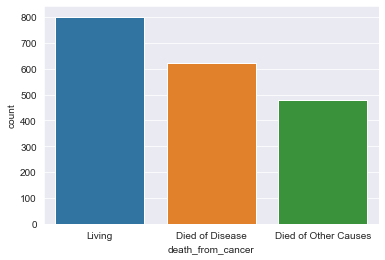

In [92]:
# countplot for target feature
sns.countplot(x='death_from_cancer', data=raw_data)
plt.show()

**<u>Findings:</u>**
The Seaborn Countplot function creates a bar chart of the number of death from cancer per category which includes 'Living', 'Died of DIsease' and 'Died of Other Causes'. From the graph, we can clearly see that the observation for 'Living' is the highest while the lowest observation came from 'Died of Other Causes'.

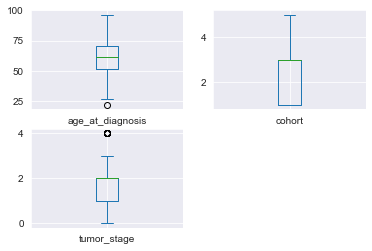

In [93]:
# boxplots of a few features
raw_plot = pd.DataFrame(raw_data, columns=['age_at_diagnosis','cohort','cellularity','tumor_stage'])
raw_plot.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
plt.show()

cellularity    AxesSubplot(0.125,0.71587;0.168478x0.16413)
dtype: object

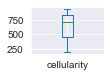

In [94]:
# box plot for a categorical data
raw_plot['cellularity'].value_counts().plot(kind='box', subplots=True, layout=(4,4), sharex=False, sharey=False)

# 3.0 Pre-Processing Methods
## 3.1 Data Cleaning

### 3.1.1 Drop Unnecessary Columns
Only clinical attributes/variables mentioned in the problem description will be used.

In [95]:
to_keep = [i for i in range(0, 31)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 31)


**<u>Findings:</u>**
By dropping unimportant columns, the number of features reduces from 693 to 31.

### 3.1.2 Define Class for Classification

In [96]:
data['death_from_cancer'].replace({'Living':0, 'Died of Other Causes':1, 'Died of Disease':2}, inplace=True)

## 3.2 Correlation between Numerical columns and Target variable

In [97]:
# calculate the correlation
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['death_from_cancer']).sort_values(ascending=False)

# filter columns with low correlation
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

**<u>Findings:</u>**
Removing outliers in numerical columns is a mandatory step to aid the training and validation process. Here, we do it by calculating the correlation between these variables with the target variables, identifying low correlation columns and filtering values less than the lower and greater than the upper bounds.

## 3.3 Check for Any Missing Data
### 3.3.1 Percentage Checking of Null Values

In [98]:
print(data.isnull().sum()/len(data)*100)

patient_id                         0.000
age_at_diagnosis                   0.000
type_of_breast_surgery             1.155
cancer_type                        0.000
cancer_type_detailed               0.788
cellularity                        2.836
chemotherapy                       0.000
pam50_+_claudin-low_subtype        0.000
cohort                             0.000
er_status_measured_by_ihc          1.576
er_status                          0.000
neoplasm_histologic_grade          3.782
her2_status_measured_by_snp6       0.000
her2_status                        0.000
tumor_other_histologic_subtype     0.788
hormone_therapy                    0.000
inferred_menopausal_state          0.000
integrative_cluster                0.000
primary_tumor_laterality           5.567
lymph_nodes_examined_positive      0.000
mutation_count                     2.363
nottingham_prognostic_index        0.000
oncotree_code                      0.788
overall_survival_months            0.000
overall_survival

**<u>Findings:</u>**
We can see that 26.3% of entries do not have tumor stage which is considered to be the highest variable with missing values, followed by other 12 features having null cells.

### 3.3.2 Identify Columns with Missing Values

In [99]:
# count the number of missing values
null_cols = data.columns[data.isnull().any()]
null_count = data[null_cols].isnull().sum()

print(null_count)

type_of_breast_surgery             22
cancer_type_detailed               15
cellularity                        54
er_status_measured_by_ihc          30
neoplasm_histologic_grade          72
tumor_other_histologic_subtype     15
primary_tumor_laterality          106
mutation_count                     45
oncotree_code                      15
3-gene_classifier_subtype         204
tumor_size                         20
tumor_stage                       501
death_from_cancer                   1
dtype: int64


Text(0.5, 1.0, 'Missing Values')

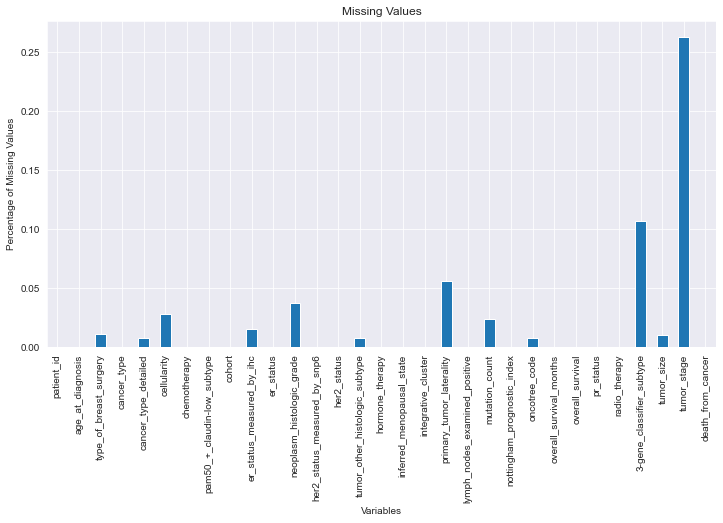

In [100]:
# plot of missing value percentage
data.isnull().mean().plot.bar(figsize=(12,6))
plt.ylabel('Percentage of Missing Values')
plt.xlabel('Variables')
plt.title('Missing Values')

## 3.4 Numerical Features' Summary Statistics
### 3.4.1 Description of the Data in the DataFrame
The describe() method returns the description of the data. If the DataFrame contains numerical data, the description contains these information for each column.

- count: The number of non-empty values.
- mean: The average (mean) value.
- std: The standard deviation values in the column.
- 25%: The 25th percentile.
- 50%: The 50th percentile.
- 75%: The 75th percentile.
- max: The maximum value which could also indicate extreme (outlier) values.

The percentiles meaning the number of values which are less than the given percentile.

In [101]:
data.describe()

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage,death_from_cancer
count,1904.000,1904.000,1904.000,1904.000,1832.000,1904.000,1904.000,1859.000,1904.000,1904.000,1904.000,1904.000,1884.000,1403.000,1903.000
mean,3921.982,61.087,0.208,2.644,2.416,0.617,2.002,5.608,4.033,125.121,0.421,0.597,26.239,1.751,0.906
std,2358.478,12.979,0.406,1.229,0.651,0.486,4.080,3.354,1.144,76.334,0.494,0.491,15.161,0.629,0.860
min,0.000,21.930,0.000,1.000,1.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000
25%,896.500,51.375,0.000,1.000,2.000,0.000,0.000,3.000,3.046,60.825,0.000,0.000,17.000,1.000,0.000
50%,4730.500,61.770,0.000,3.000,3.000,1.000,0.000,5.000,4.042,115.617,0.000,1.000,23.000,2.000,1.000
75%,5536.250,70.593,0.000,3.000,3.000,1.000,2.000,7.000,5.040,184.717,1.000,1.000,30.000,2.000,2.000
max,7299.000,96.290,1.000,5.000,3.000,1.000,45.000,19.000,6.360,355.200,1.000,1.000,182.000,4.000,2.000


### 3.4.2 Plot the Boxplots of Numerical Variables

In [102]:
# function that takes a dataframe and transforms it into a standard for after dropping non-numerical columns
def to_standard(data):
    num_df = data[data.select_dtypes(include=np.number).columns.tolist()]

    ss = StandardScaler()
    std = ss.fit_transform(num_df)

    std_df = pd.DataFrame(std, index=num_df.index, columns=num_df.columns)
    return std_df

(15.0, -1.0)

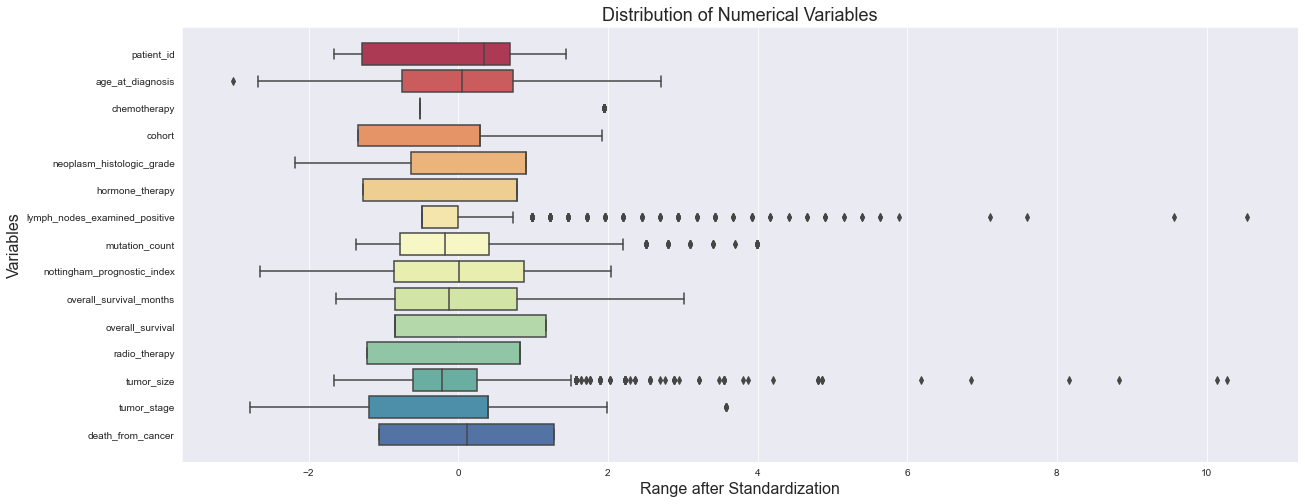

In [103]:
# plot the boxplots of numerical variables
ax, fig = plt.subplots(1, 1, figsize=(20,8))
plt.title('Distribution of Numerical Variables', fontsize=18)

sns.boxplot(y='variable', x='value', data=pd.melt(to_standard(data)), palette='Spectral')
plt.xlabel('Range after Standardization', size=16)
plt.ylabel('Variables', size=16)

# fix for mpl bug that cuts off top/bottom of seaborn visualization
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # add 0.5 to the bottom
t -= 0.5 # subtract 0.5 from the top
plt.ylim(b,t) # update the ylim(bottom,top) values

**<u>Findings</u>**
By looking at the boxplots, some variables have outlier(s) such as *chemotherapy, lymph_nodes_examined_positive, mutation_count, tumor_size*, and *tumor_stage*.

## 3.5 Categorical Features' Summary Statistics
We will use the Panda's df.describe (include='object') that only displays the analysis of the features that have the datatype 'object'.

- count: Number of missing values that are present if the count is less than the total rows of the dataframe.
- unique: The number of unique classes.
- top: The top most common value or class in which if there are multiple values have highest occurrence, an arbitary top (and frequency) values will be displayed.
- freq: The frequency or the number of occurrences of the top class.

In [104]:
data.describe(include='object')

,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,pam50_+_claudin-low_subtype,er_status_measured_by_ihc,er_status,her2_status_measured_by_snp6,her2_status,tumor_other_histologic_subtype,inferred_menopausal_state,integrative_cluster,primary_tumor_laterality,oncotree_code,pr_status,3-gene_classifier_subtype
count,1882,1904,1889,1850,1904,1874,1904,1904,1904,1889,1904,1904,1798,1889,1904,1700
unique,2,2,6,3,7,2,2,4,2,8,2,11,2,6,2,4
top,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,LumA,Positve,Positive,NEUTRAL,Negative,Ductal/NST,Post,8,Left,IDC,Positive,ER+/HER2- Low Prolif
freq,1127,1903,1500,939,679,1445,1459,1383,1668,1454,1493,289,935,1500,1009,619


**<u>Findings:</u>**
The highest number of unique class belongs to the integrative_cluster feature.

### 3.5.1 Categorical Distribution
We will plot the categorical features to see how the classes are distributed for each feature seaborn's countplot will be used which is like a bar graph where each bar represents a class and the height is the number of values in that class. By using the summary statistics above, the highest number of unique class belongs to the integrative_cluster feature. Hence, the plot of the countplot will be 11 or fewer unique classes.

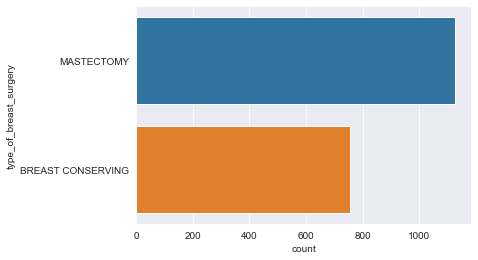

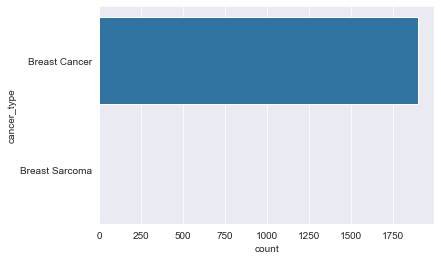

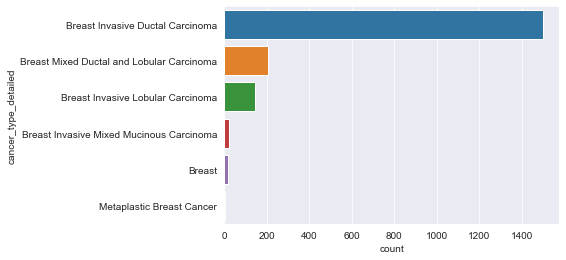

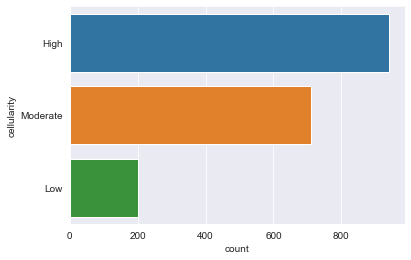

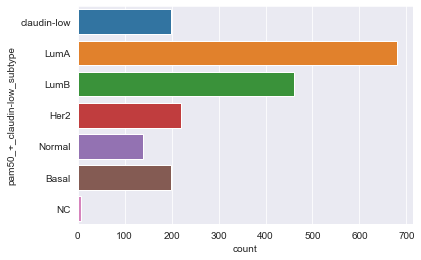

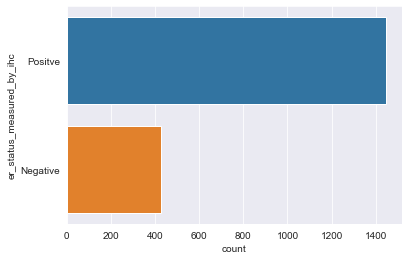

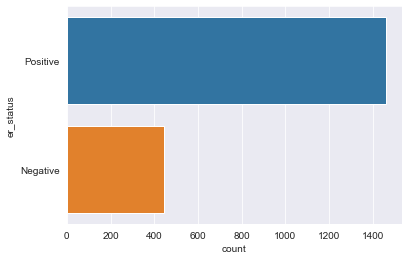

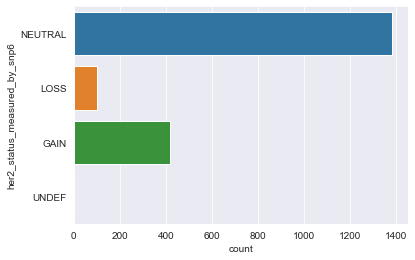

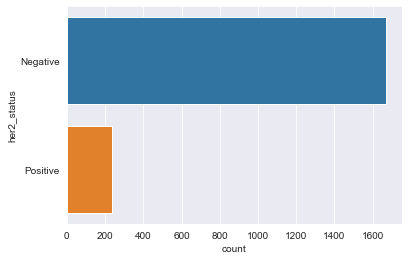

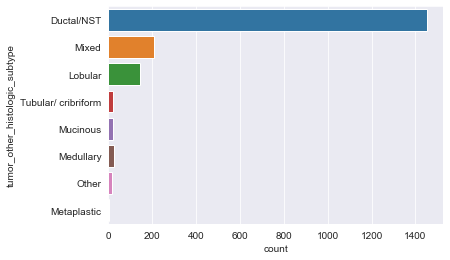

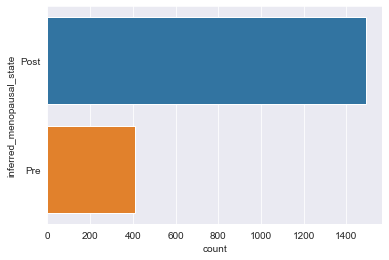

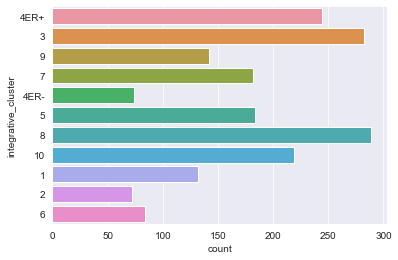

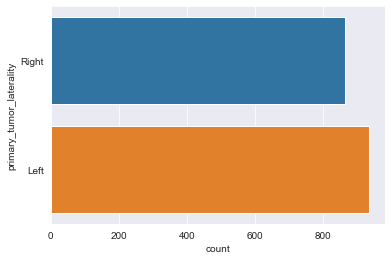

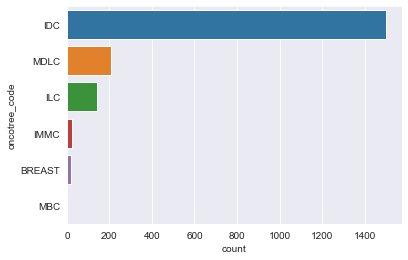

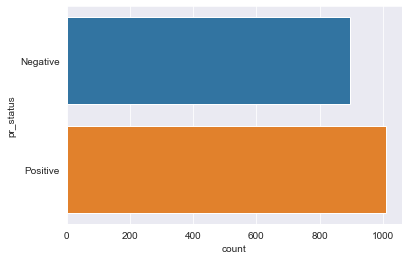

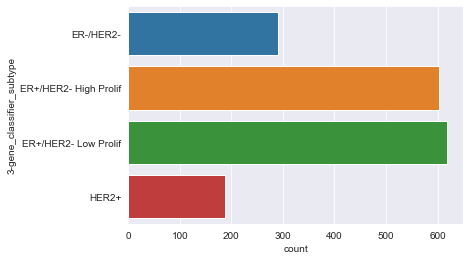

In [105]:
# 11 or fewer unique classes will be plotted
for col in data.select_dtypes(include='object'):
    if data[col].nunique() <= 11:
        sns.countplot(y=col, data=data)
        plt.show()

**<u>Findings:</u>**
We can now see the distributions of classes in the various categorical features.

### 3.5.2 Tabulate Across Various Categorical Features (Cross Tab)
The Panda's .crostab(col1,col2) function builds a cross-tabulation table that shows the relationship between two categorical features. The table shows the frequency by which groups of data from the two features appear. The normalize='index' to show the percentages across the rows instead of the real numbers. 

In [106]:
for col in data.select_dtypes(include='object'):
    if data[col].nunique() <=11:
        display(pd.crosstab(data['death_from_cancer'], data[col], normalize='index'))

type_of_breast_surgery,BREAST CONSERVING,MASTECTOMY
death_from_cancer,,
0.0,0.509,0.491
1.0,0.323,0.677
2.0,0.321,0.679


cancer_type,Breast Cancer,Breast Sarcoma
death_from_cancer,,
0.0,0.999,0.001
1.0,1.000,0.000
2.0,1.000,0.000


cancer_type_detailed,Breast,Breast Invasive Ductal Carcinoma,Breast Invasive Lobular Carcinoma,Breast Invasive Mixed Mucinous Carcinoma,Breast Mixed Ductal and Lobular Carcinoma,Metaplastic Breast Cancer
death_from_cancer,,,,,,
0.0,0.015,0.798,0.073,0.016,0.097,0.000
1.0,0.004,0.764,0.080,0.011,0.139,0.002
2.0,0.005,0.811,0.074,0.006,0.103,0.000


cellularity,High,Low,Moderate
death_from_cancer,,,
0.0,0.508,0.119,0.373
1.0,0.498,0.105,0.397
2.0,0.515,0.095,0.390


pam50_+_claudin-low_subtype,Basal,Her2,LumA,LumB,NC,Normal,claudin-low
death_from_cancer,,,,,,,
0.0,0.110,0.081,0.393,0.197,0.001,0.080,0.137
1.0,0.062,0.100,0.452,0.254,0.004,0.058,0.069
2.0,0.130,0.172,0.235,0.291,0.005,0.077,0.090


er_status_measured_by_ihc,Negative,Positve
death_from_cancer,,
0.0,0.239,0.761
1.0,0.128,0.872
2.0,0.293,0.707


er_status,Negative,Positive
death_from_cancer,,
0.0,0.243,0.757
1.0,0.133,0.867
2.0,0.299,0.701


her2_status_measured_by_snp6,GAIN,LOSS,NEUTRAL,UNDEF
death_from_cancer,,,,
0.0,0.202,0.061,0.735,0.001
1.0,0.175,0.037,0.785,0.002
2.0,0.275,0.051,0.670,0.003


her2_status,Negative,Positive
death_from_cancer,,
0.0,0.889,0.111
1.0,0.935,0.065
2.0,0.814,0.186


tumor_other_histologic_subtype,Ductal/NST,Lobular,Medullary,Metaplastic,Mixed,Mucinous,Other,Tubular/ cribriform
death_from_cancer,,,,,,,,
0.0,0.766,0.073,0.014,0.000,0.097,0.016,0.015,0.019
1.0,0.743,0.080,0.011,0.002,0.139,0.011,0.004,0.011
2.0,0.795,0.074,0.015,0.000,0.103,0.006,0.005,0.002


inferred_menopausal_state,Post,Pre
death_from_cancer,,
0.0,0.702,0.298
1.0,0.956,0.044
2.0,0.757,0.243


integrative_cluster,1,10,2,3,4ER+,4ER-,5,6,7,8,9
death_from_cancer,,,,,,,,,,,
0.0,0.071,0.144,0.025,0.166,0.151,0.042,0.072,0.032,0.092,0.145,0.059
1.0,0.050,0.065,0.033,0.204,0.127,0.029,0.050,0.044,0.127,0.196,0.075
2.0,0.082,0.117,0.058,0.082,0.100,0.042,0.164,0.059,0.074,0.127,0.095


primary_tumor_laterality,Left,Right
death_from_cancer,,
0.0,0.493,0.507
1.0,0.533,0.467
2.0,0.546,0.454


oncotree_code,BREAST,IDC,ILC,IMMC,MBC,MDLC
death_from_cancer,,,,,,
0.0,0.015,0.798,0.073,0.016,0.000,0.097
1.0,0.004,0.764,0.080,0.011,0.002,0.139
2.0,0.005,0.811,0.074,0.006,0.000,0.103


pr_status,Negative,Positive
death_from_cancer,,
0.0,0.457,0.543
1.0,0.390,0.610
2.0,0.550,0.450


3-gene_classifier_subtype,ER+/HER2- High Prolif,ER+/HER2- Low Prolif,ER-/HER2-,HER2+
death_from_cancer,,,,
0.0,0.290,0.413,0.197,0.101
1.0,0.400,0.438,0.113,0.049
2.0,0.406,0.242,0.181,0.172


**<u>Findings:</u>**
These tables show how the categorical features' classes are split among the death_from_cancer's classes.

### 3.5.3 Count Plot of Death_From_Cancer Across Various Categorical Features
We plot the categorical relationships above to get a better feel of the interactions. We create count plots of the data using Seaborn's catplot() function and provide kind='count as a parameter, which selects a count plot as the underlying axes-level function to use.

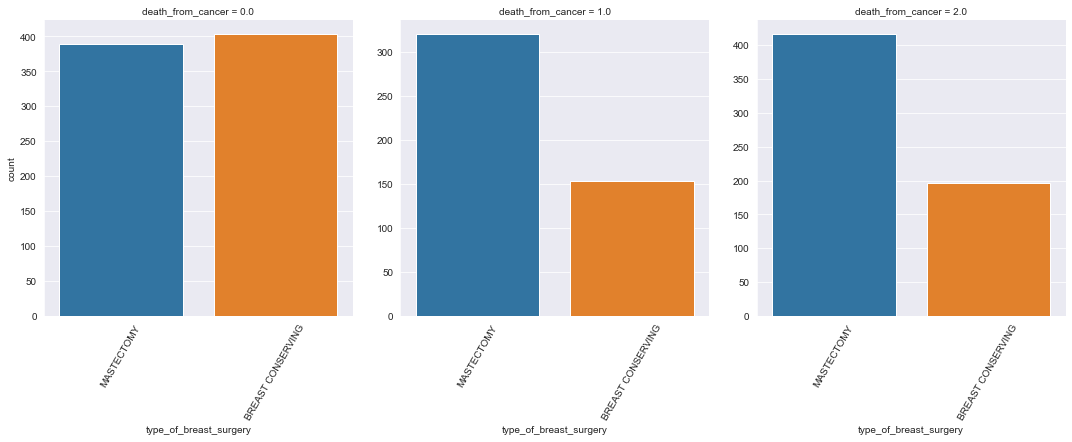

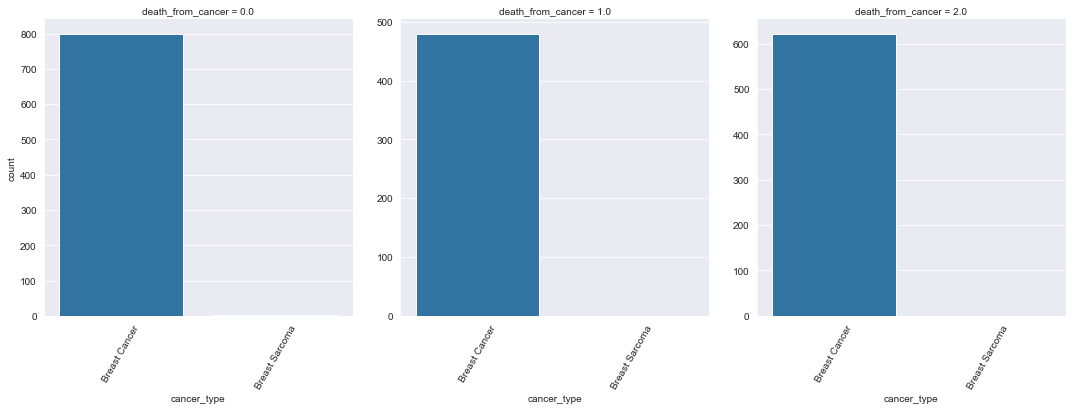

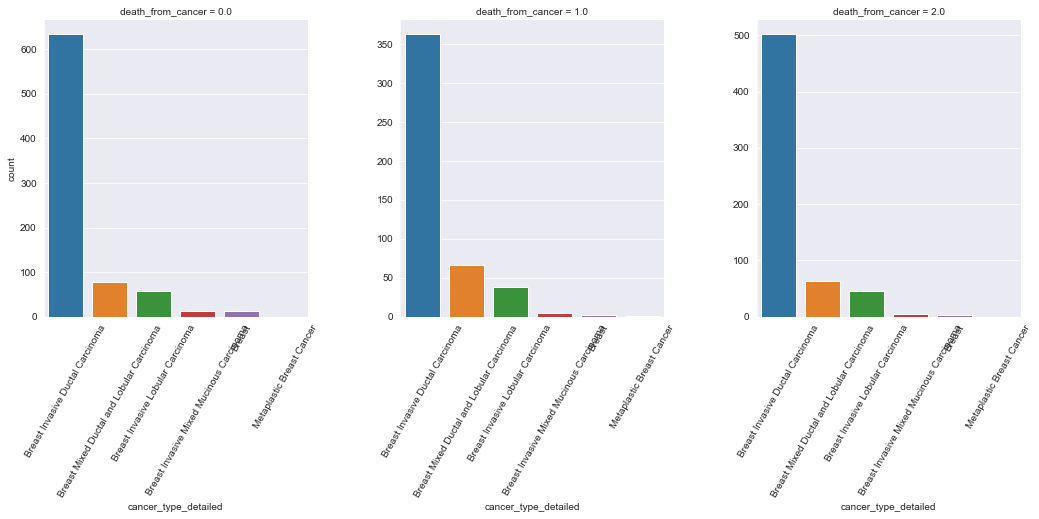

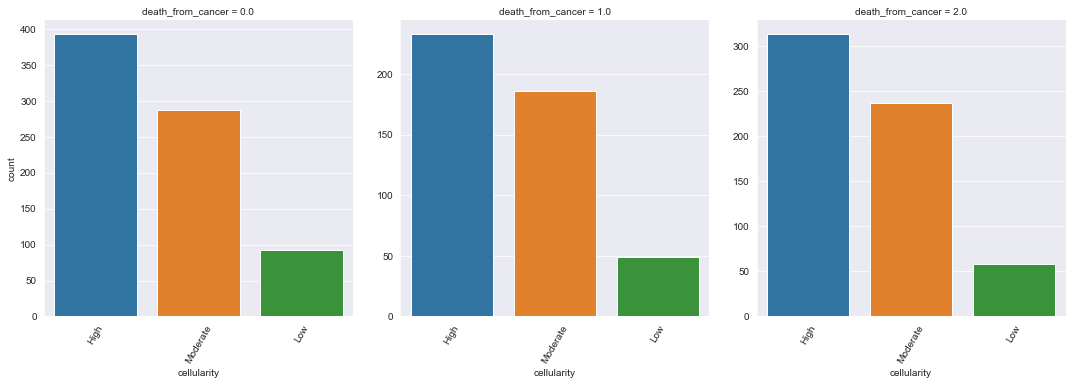

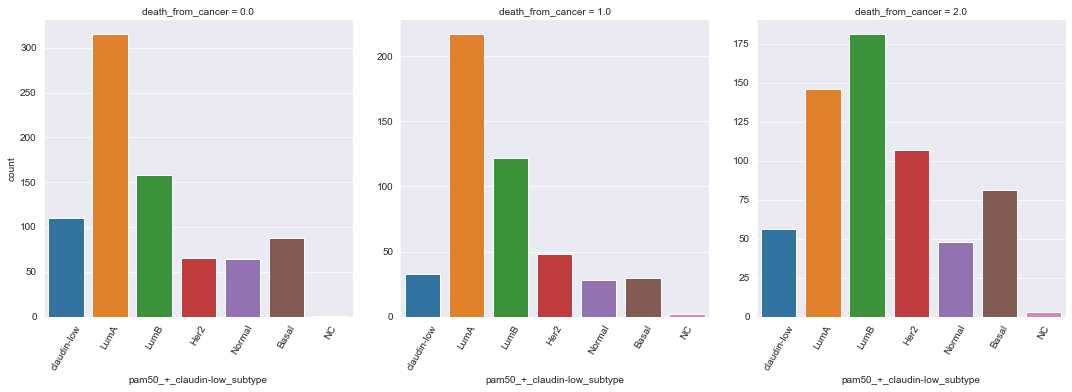

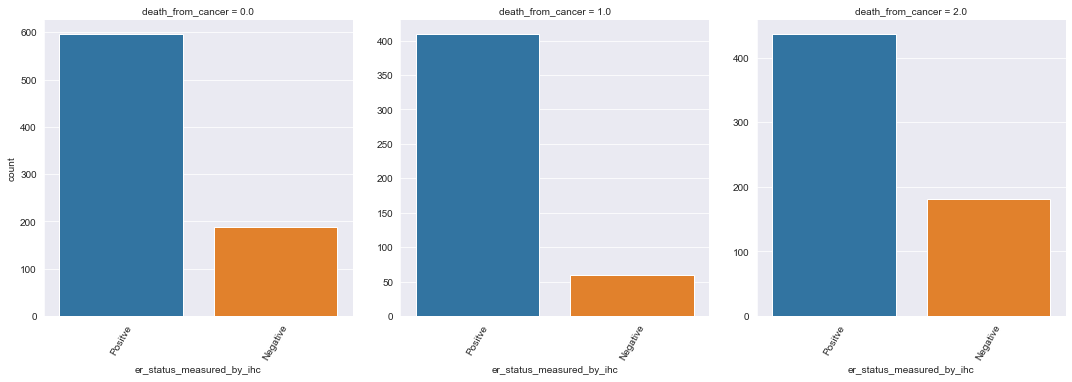

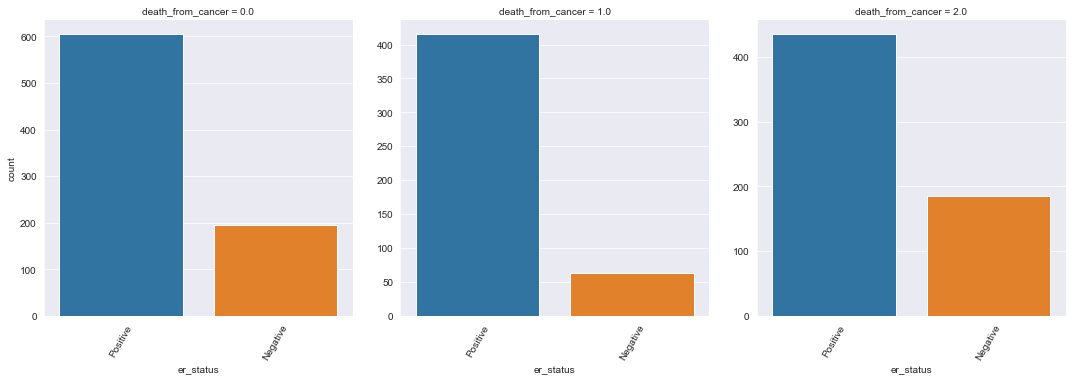

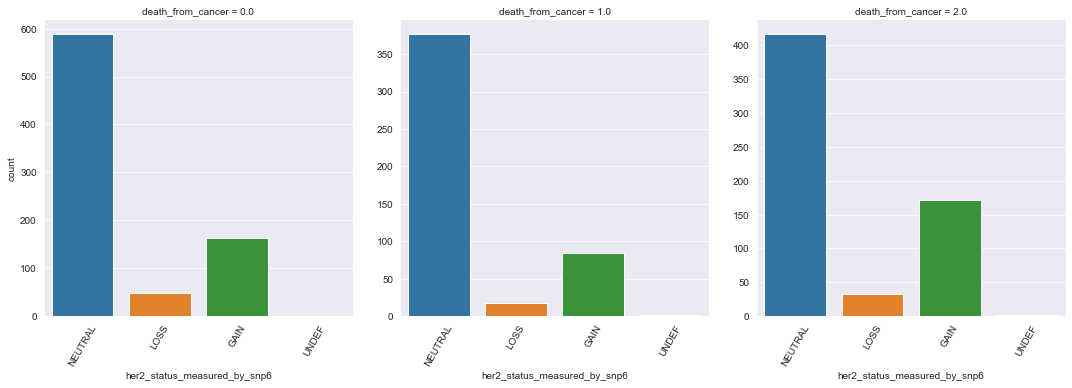

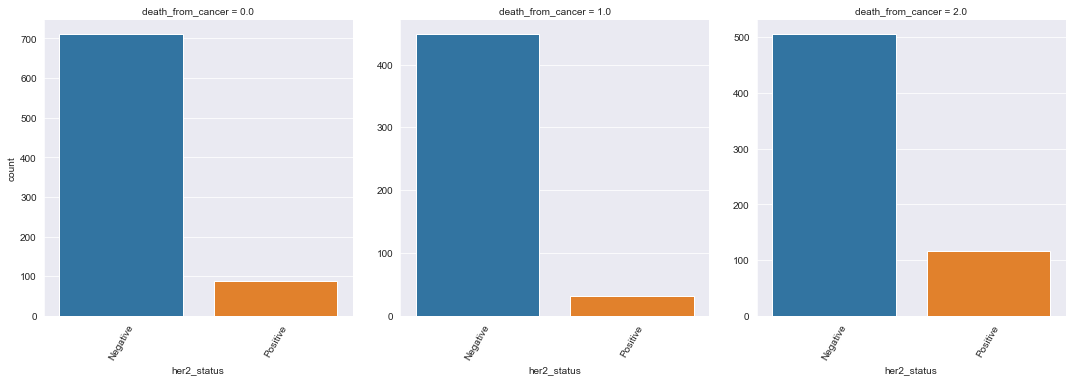

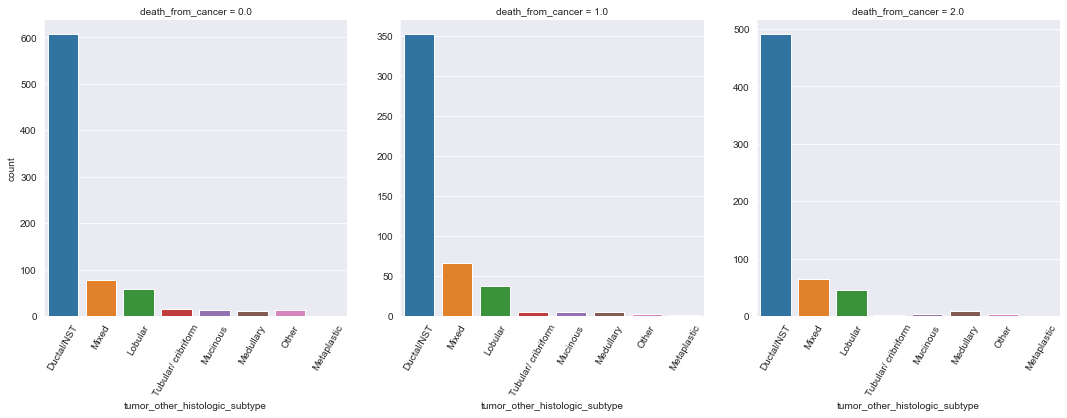

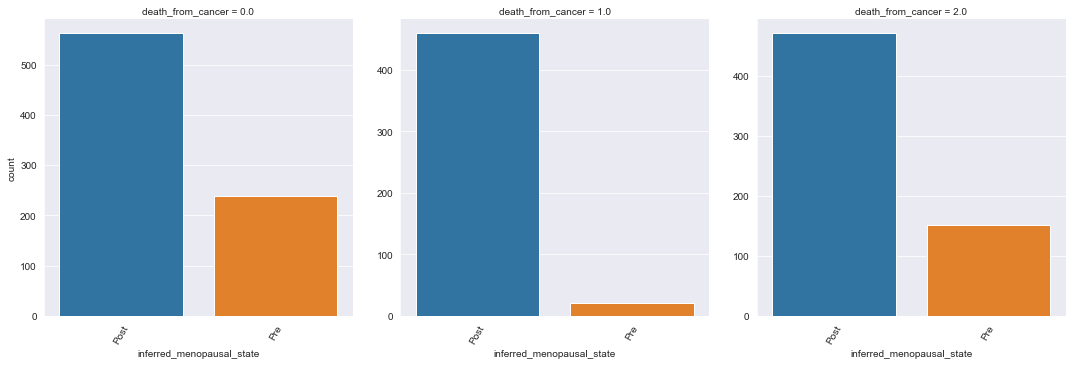

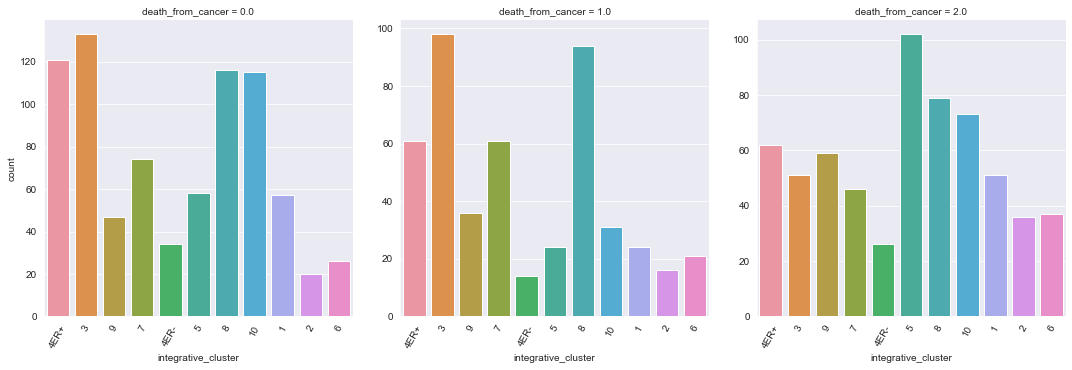

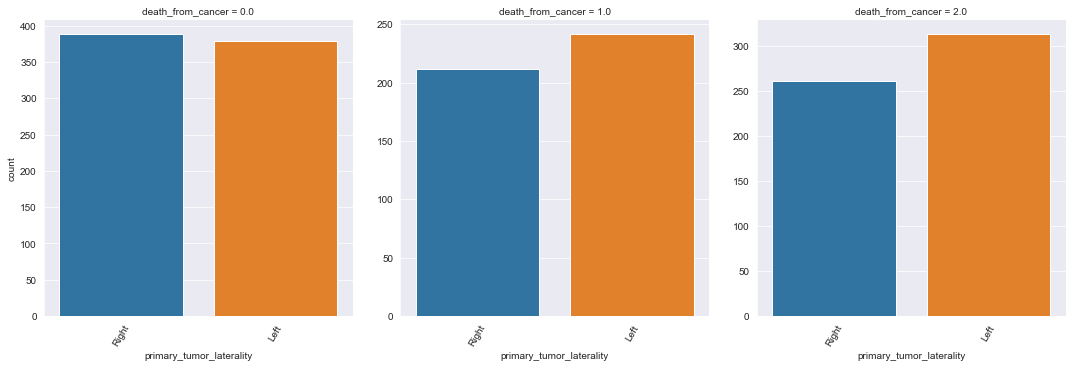

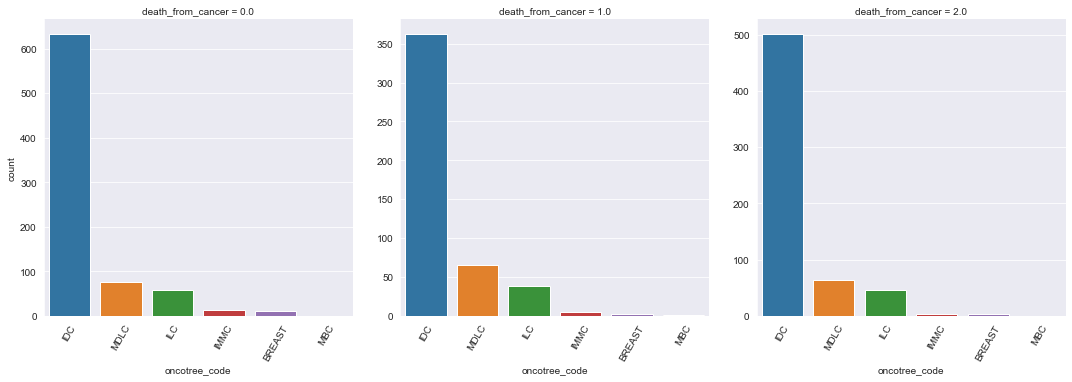

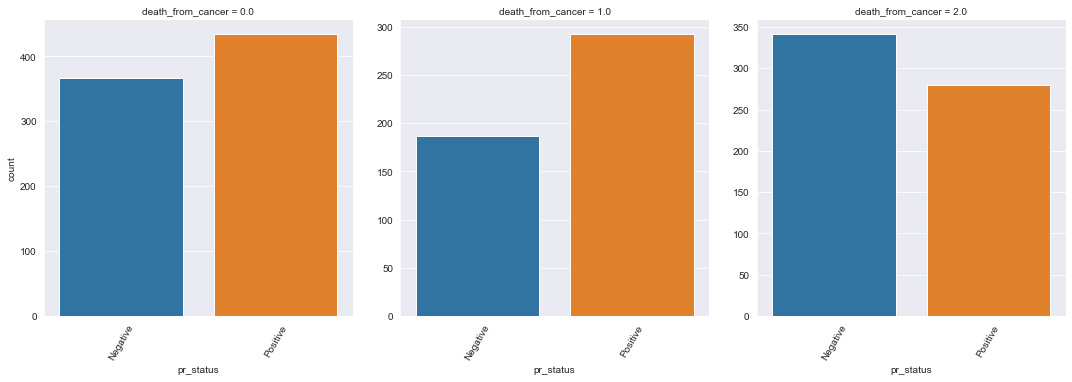

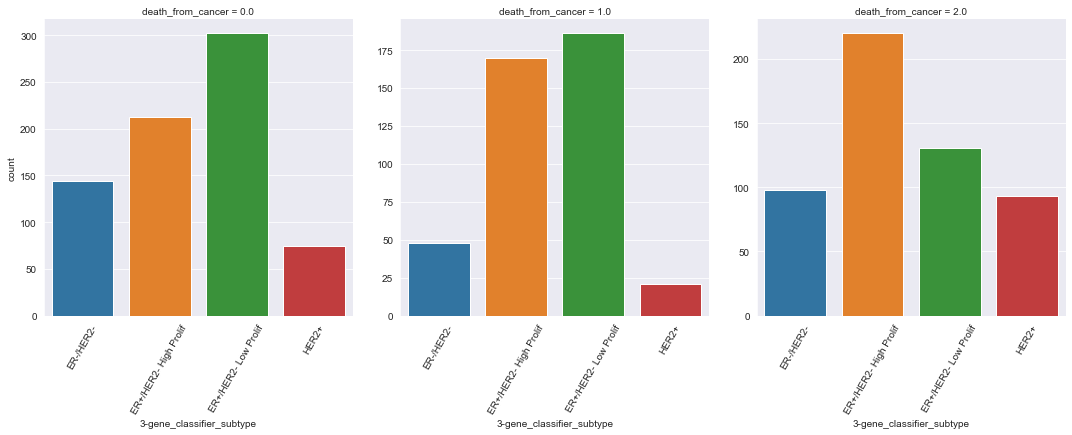

In [107]:
for col in data.select_dtypes(include='object'):
    if data[col].nunique() <= 11:
        g = sns.catplot(x=col, kind='count', col='death_from_cancer', data=data, sharey=False)
        g.set_xticklabels(rotation=60)

**<u>Findings:</u>**
We can see that the *cancer_type, cancer_type_detailed, cellularity, tumor_other_histologic_subtype* and *oncotree_code* classes do not change much depending on the target, but there is a significant among *type_of_breast_surgery, pam50_+_claudin-low_subtype, er_status_measured_by_ihc, er_status, her2_status_measured_by_snp6, her2_status, inferred_menopausal_state, integrative_cluster, primary_tumor_laterality, pr_status* and *3-gene_classifier_subtype*.

## 3.6 Correlation Matrix for the Various Numeric Features
A correlation matrix is a table used to summarize the associations between numeric features. The same features are shown in the rows and columns, and each cell hold the **correlation coefficient** of two features. The correlation coefficient is a measure of the *strength of the relationship* between the two variables and can take any value between -1 and 1. The correlation of a feature with itself is 1.

In [108]:
corr = data.corr()
corr

,patient_id,age_at_diagnosis,chemotherapy,cohort,neoplasm_histologic_grade,hormone_therapy,lymph_nodes_examined_positive,mutation_count,nottingham_prognostic_index,overall_survival_months,overall_survival,radio_therapy,tumor_size,tumor_stage,death_from_cancer
patient_id,1.000,0.031,-0.151,0.934,-0.016,-0.091,-0.043,0.294,-0.047,0.100,-0.148,-0.175,-0.004,-0.090,0.100
age_at_diagnosis,0.031,1.000,-0.417,0.061,-0.114,0.287,-0.007,0.002,-0.088,-0.150,-0.304,-0.135,0.047,0.086,0.156
chemotherapy,-0.151,-0.417,1.000,-0.133,0.286,-0.163,0.284,-0.071,0.431,-0.160,0.046,0.228,0.196,0.338,0.064
cohort,0.934,0.061,-0.133,1.000,-0.052,-0.117,-0.026,0.273,-0.055,0.089,-0.150,-0.221,0.018,-0.071,0.092
neoplasm_histologic_grade,-0.016,-0.114,0.286,-0.052,1.000,-0.051,0.149,0.067,0.721,-0.122,-0.087,0.142,0.134,0.179,0.141
hormone_therapy,-0.091,0.287,-0.163,-0.117,-0.051,1.000,0.129,-0.136,0.134,-0.106,-0.030,0.088,0.062,0.220,0.007
lymph_nodes_examined_positive,-0.043,-0.007,0.284,-0.026,0.149,0.129,1.000,-0.050,0.563,-0.240,-0.164,0.127,0.265,0.447,0.227
mutation_count,0.294,0.002,-0.071,0.273,0.067,-0.136,-0.050,1.000,0.012,0.048,-0.075,-0.098,0.021,-0.021,0.054
nottingham_prognostic_index,-0.047,-0.088,0.431,-0.055,0.721,0.134,0.563,0.012,1.000,-0.243,-0.138,0.222,0.280,0.547,0.227
overall_survival_months,0.100,-0.150,-0.160,0.089,-0.122,-0.106,-0.240,0.048,-0.243,1.000,0.384,-0.006,-0.188,-0.273,-0.460


### 3.6.1 Heat Map of the Correlations
A heat map refers to a color-coded representation of data where the values are portrayed by color. We use the Seaborn heatmap to visualize our grid above.

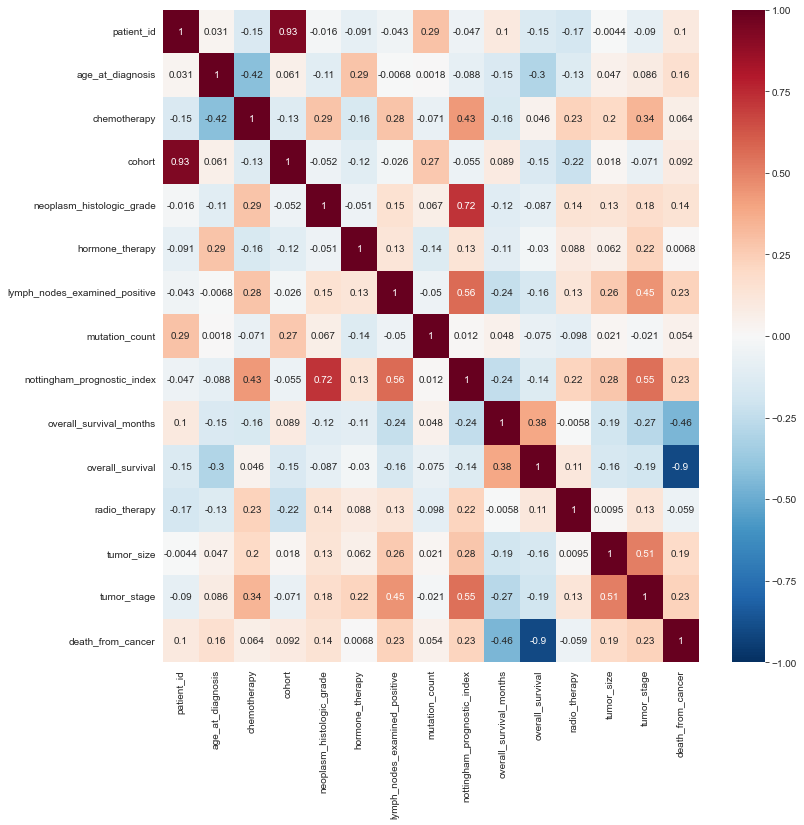

In [109]:
plt.figure(figsize=(12,12))
sns.heatmap(corr, cmap='RdBu_r', annot=True, vmax=1, vmin=-1)
plt.show()

**<u>Findings:</u>**
We see that patient_id and cohort have somewhat strong positive correlation, followed by *neoplasm_histologic_grade* and *nottingham_prognoostic_index*. We also see a slightly weak negative relationship between the *overall_survival* and *death_from_cancer*.

## 3.7 Impute Missing Values with 'mode' Values

In [110]:
# imputation of missing values with 'mode' values in important columns
cols_to_fill = ["type_of_breast_surgery","cancer_type_detailed","cellularity",
                "er_status_measured_by_ihc","neoplasm_histologic_grade","tumor_other_histologic_subtype",
                "primary_tumor_laterality","mutation_count","3-gene_classifier_subtype",
                "tumor_size","tumor_stage"]

for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [111]:
# make a copy after complete the dataframe using 'mode' values
df = data.copy(deep=True)

# convert strings into categorical classes
cols_to_convert = ["type_of_breast_surgery","cellularity","er_status_measured_by_ihc",
                    "her2_status","inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING':1, 'MASTECTOMY':0},
                "cellularity": {"High": 2, "Moderate": 1, "Low": 0},
                "er_status_measured_by_ihc": {"Positve": 1, "Negative": 0},
                "her2_status": {"Positive": 1, "Negative": 0},
                "inferred_menopausal_state": {"Post": 1, "Pre": 0},
                "pr_status": {"Positive": 1, "Negative": 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

## 3.8 One-Hot Encoding

In [112]:
# use One-Hot-Encoding to convert categorical features into numeric features
df = pd.get_dummies(data=df, columns=['cancer_type','cancer_type_detailed','er_status',
                                    'her2_status_measured_by_snp6','pam50_+_claudin-low_subtype',
                                    'tumor_other_histologic_subtype','integrative_cluster',
                                    'primary_tumor_laterality','3-gene_classifier_subtype'])

## 3.9 Drop Rows with Missing Values

In [113]:
df.dropna(inplace=True)
print(df.shape)

(1888, 68)


In [114]:
# compare sizes of dataframes
print("Old data frame length:", len(raw_data))
print("New data frame length:", len(df))

Old data frame length: 1904
New data frame length: 1888


# 4.0 Exploratory Data Analysis (EDA)
## 4.1 Relationship Between Variables

### 4.1.1 Is there any relationship between age_at_diagnosis and er_status?

In [115]:
df_er_age = data.copy()
df_er_age = df_er_age[['er_status','age_at_diagnosis']]
df_er_age.head()

,er_status,age_at_diagnosis
0,Positive,75.65
1,Positive,43.19
2,Positive,48.87
3,Positive,47.68
4,Positive,76.97


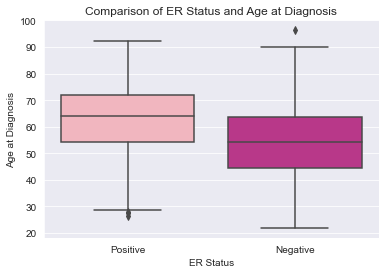

In [116]:
#comparative boxplot
sns.set_style("darkgrid")
sns.boxplot(data=df_er_age, x="er_status", y="age_at_diagnosis",
            palette="RdPu")
plt.title('Comparison of ER Status and Age at Diagnosis')
plt.xlabel('ER Status')
plt.ylabel('Age at Diagnosis')
plt.show()

In [117]:
# statistics test -One way anova
stats.f_oneway(df_er_age["age_at_diagnosis"][df_er_age['er_status'] == 'Positive'],
               df_er_age["age_at_diagnosis"][df_er_age['er_status'] == 'Negative'])


F_onewayResult(statistic=158.63458786714887, pvalue=5.378320992390348e-35)

Null hypothesis = $H_0$: μ1=μ2
Alternate hypothesis = $H_a$: μ1≠μ2

The F test stastistic calculated above is 158.635 and the corresponding p-value is 5.378e-35. Since the p-value is less than 0.05, we have to reject $H_0$ (null hypothesis). Thus, we do have sufficient evidence to say that the different type of ER Status (Positive and Negative) affects the ages at diagnosis.

### 4.1.2 Is there any relationship between age_at_diagnosis and cellularity?

In [118]:
data

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,nottingham_prognostic_index,oncotree_code,overall_survival_months,overall_survival,pr_status,radio_therapy,3-gene_classifier_subtype,tumor_size,tumor_stage,death_from_cancer
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,claudin-low,1.0,Positve,...,6.044,IDC,140.500,1,Negative,1,ER-/HER2-,22.0,2.0,0.0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,4.020,IDC,84.633,1,Positive,1,ER+/HER2- High Prolif,10.0,1.0,0.0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,4.030,IDC,163.700,0,Positive,0,ER+/HER2- Low Prolif,15.0,2.0,2.0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,4.050,MDLC,164.933,1,Positive,1,ER+/HER2- Low Prolif,25.0,2.0,0.0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,6.080,MDLC,41.367,0,Positive,1,ER+/HER2- High Prolif,40.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,7295,43.10,BREAST CONSERVING,Breast Cancer,Breast Invasive Lobular Carcinoma,High,0,LumA,4.0,Positve,...,5.050,ILC,196.867,1,Positive,1,ER+/HER2- Low Prolif,25.0,2.0,0.0
1900,7296,42.88,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,5.040,IDC,44.733,0,Negative,1,ER+/HER2- Low Prolif,20.0,2.0,2.0
1901,7297,62.90,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumB,4.0,Positve,...,6.050,IDC,175.967,0,Positive,1,ER+/HER2- Low Prolif,25.0,2.0,2.0
1902,7298,61.16,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,Moderate,0,LumB,4.0,Positve,...,5.050,IDC,86.233,0,Positive,0,ER+/HER2- High Prolif,25.0,2.0,1.0


In [119]:
data.columns

Index(['patient_id', 'age_at_diagnosis', 'type_of_breast_surgery', 'cancer_type',
       'cancer_type_detailed', 'cellularity', 'chemotherapy', 'pam50_+_claudin-low_subtype',
       'cohort', 'er_status_measured_by_ihc', 'er_status', 'neoplasm_histologic_grade',
       'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype',
       'hormone_therapy', 'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive', 'mutation_count',
       'nottingham_prognostic_index', 'oncotree_code', 'overall_survival_months',
       'overall_survival', 'pr_status', 'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage', 'death_from_cancer'],
      dtype='object')

In [120]:
df_age_cell = data.copy()
df_age_cell = df_age_cell[["age_at_diagnosis","cellularity"]]
df_age_cell.head()

,age_at_diagnosis,cellularity
0,75.65,High
1,43.19,High
2,48.87,High
3,47.68,Moderate
4,76.97,High


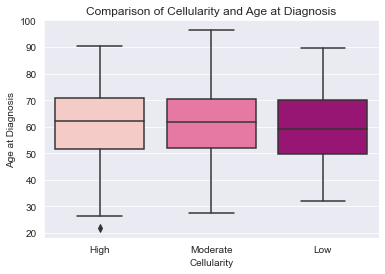

In [121]:
#comparative boxplot
sns.set_style("darkgrid")
sns.boxplot(data=df_age_cell, x="cellularity", y="age_at_diagnosis",palette="RdPu")
plt.title('Comparison of Cellularity and Age at Diagnosis')
plt.xlabel('Cellularity')
plt.ylabel('Age at Diagnosis')
plt.show()

In [122]:
#Statistics test -One way anova

stats.f_oneway(df_age_cell["age_at_diagnosis"][df_age_cell['cellularity'] == 'High'],
               df_age_cell["age_at_diagnosis"][df_age_cell['cellularity'] == 'Moderate'],
               df_age_cell["age_at_diagnosis"][df_age_cell['cellularity'] == 'Low'])

F_onewayResult(statistic=2.278344399173266, pvalue=0.10273338272668969)

Null hypothesis = $H_0$: μ1=μ2
Alternate hypothesis = $H_a$: μ1≠μ2

The F test stastistic calculated above is 2.278 and the corresponding p-value is 0.103. Since the p-value is more than 0.05, we have failed to reject $H_0$ (null hypothesis). Thus, we do not have sufficient evidence to say that the different type of Cellularity (High, Moderate and Low) affects the ages at diagnosis.

### 4.1.3 What is the Distribution of Survival Time and Age at Diagnosis with Death from Cancer?

In [123]:
df_time_age = data.copy()

died = df_time_age[df_time_age['overall_survival']==0]
survived = df_time_age[df_time_age['overall_survival']==1]

#alive_from_cancer = df_time_age[df_time_age['death_from_cancer']=='Living']
#died_from_cancer = df_time_age[df_time_age['death_from_cancer']=='Died of Disease']
#died_not_cancer = df_time_age[df_time_age['death_from_cancer']=='Died of Other Causes']

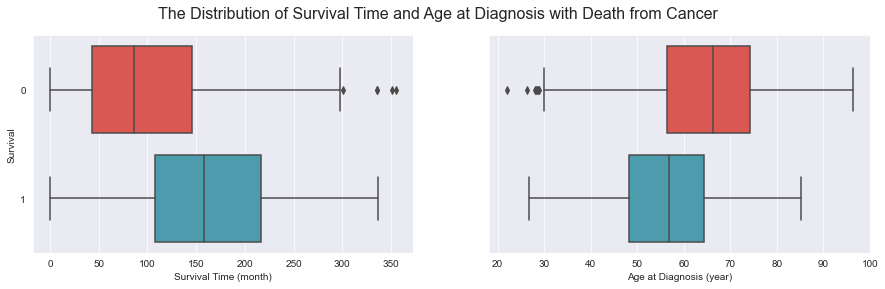

In [124]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4), sharey=True)

sns.boxplot(x='overall_survival_months', y='overall_survival', orient='h', data=df_time_age, ax=ax[0], palette=two_colors, saturation=0.90)
sns.boxplot(x='age_at_diagnosis', y='overall_survival', orient='h', data=df_time_age, ax=ax[1], palette=two_colors, saturation=0.90)

fig.suptitle('The Distribution of Survival Time and Age at Diagnosis with Death from Cancer', fontsize=16)

ax[0].set_xlabel('Survival Time (month)')
ax[0].set_ylabel('Survival')
ax[1].set_xlabel('Age at Diagnosis (year)')
ax[1].set_ylabel('')

plt.show()

**<u>Findings:</u>**
- The difference between the two distributions in *age_at_diagnosis* column, as patients who were older when diagnosed with breast cancer were more likely to not survive.
- The duration from the time of the intervention to death or to current time is longer in the patients who survive. That means that patients are either dying early from breast cancer or surviving.

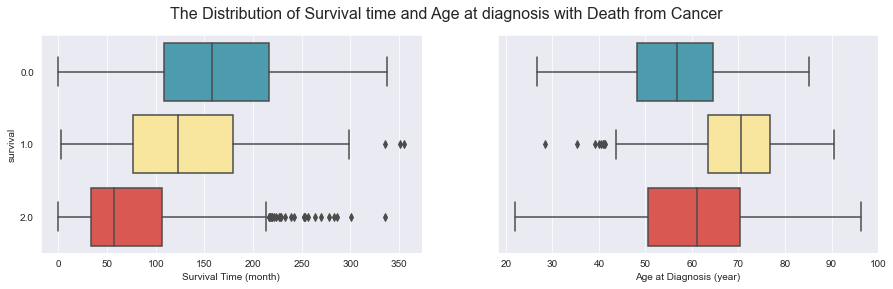

In [125]:
fig, ax = plt.subplots(ncols=2, figsize=(15,4), sharey=True)

sns.boxplot(x='overall_survival_months', y='death_from_cancer', orient='h', data=df_time_age, ax=ax[0], palette = three_colors, saturation=0.90)
sns.boxplot(x='age_at_diagnosis', y='death_from_cancer', orient='h', data=df_time_age, ax=ax[1], palette = three_colors, saturation=0.90)

fig.suptitle('The Distribution of Survival time and Age at diagnosis with Death from Cancer', fontsize = 16)

ax[0].set_xlabel('Survival Time (month)')
ax[0].set_ylabel('survival')
ax[1].set_xlabel('Age at Diagnosis (year)')
ax[1].set_ylabel('')

plt.show()

**<u>Notes:</u>**
**Survival**:
0 - Living
1 - Died of Other Causes
2 - Died of Disease

**<u>Findings:</u>**
- Patients who survived from breast are more likely to survive longer compared to patients who died because of breast cancer and person who died because of other disease.
- Patients with breast cancer are more likely to die faster than a person who died because of other disease.
- Patients whose age at diagnosis > 60 are more likely to die because of other disease.
-  Patients who were younger tend to die because of breast cancer or survive from breast cancer.

### 4.1.4 What is the Distribution of Tumor Size per Tumor Stage?

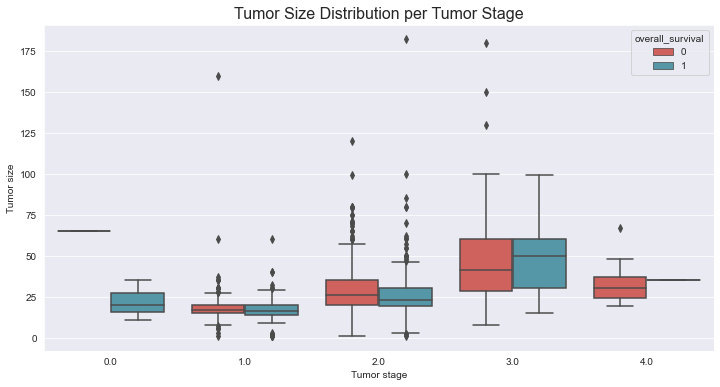

In [126]:
df_tumor = data.copy()

ig, ax = plt.subplots(figsize=(12,6))
ax = sns.boxplot(x ='tumor_stage', y ='tumor_size',  data = df_tumor, orient='v', hue='overall_survival', palette=two_colors)

ax.set_ylabel('Tumor size')
ax.set_xlabel('Tumor stage')
plt.title('Tumor Size Distribution per Tumor Stage', fontsize=16)
plt.show()

**<u>Findings:</u>**
**Stage 0.0**
- Patients who died have same tumor size, around 60-70.
- Patients who survived have tumor size between 15-35.

**Stage 1.0**
- Patients who died and survived has relatively same tumor size distribution, except 1 died patients whose tumor size > 150.

**Stage 2.0**
- patients who died and survived has a little bit difference in tumor size distribution and has almost the same median.

**Stage 3.0**
- Patients who died have variety of tumor size, from around 10 to more than 175.
- Patients who survived have tumor size between around 20 and 100.

**Stage 4.0**
- Patients who died have tumor size between 20-70.
- Patients who survived have same tumor size, around 60-70.

# 5.0 Feature Engineering
## 5.1 Feature Selection

In [127]:
# select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    X = np.array(X)    
    y = np.array(y)
    
    # plot feature scores
    a = best_features['fname']
    b = best_features['score']    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

## 5.2 Split Dataset
Split the dataset into train and test sets

C:\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


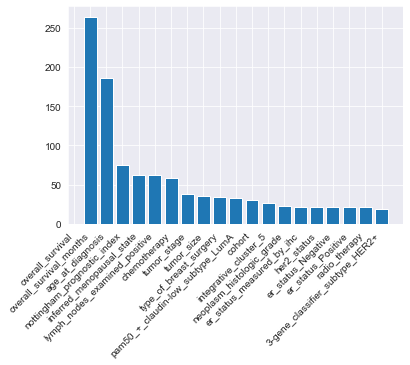

In [128]:
X = df.drop(columns=['death_from_cancer','patient_id','oncotree_code'], axis=1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## 5.3 Data Transformation

In [129]:
# standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1416, 20) (472, 20)
(1416,) (472,)


# 6.0 Evaluate Algorithms
## 6.1 Ensemble Algorithm (XGBoost)
In this section, we used XGBoost model for the training and validation processes.

In [130]:
# define model
model1 = XGBClassifier(use_label_encoder=False)

# use DMatrix to convert input data into internal data structure that is optimized for both memory efficiency and training speed
df_xgb = xgb.DMatrix(data=X, label=y)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.3)

model1.fit(X_train1, y_train1)

# make predictions for test data
pred = model1.predict(X_test1)

# evaluate predictions
accuracy = accuracy_score(y_test1, pred)
print('Accuracy: %.2f%%' % (accuracy * 100.00))

C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy: 81.66%


In [131]:
print(classification_report(y_test1, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       250
         1.0       0.67      0.63      0.65       154
         2.0       0.67      0.71      0.69       163

    accuracy                           0.82       567
   macro avg       0.78      0.78      0.78       567
weighted avg       0.82      0.82      0.82       567



**<u>Findings:</u>**
The training accuracy of XGBoostClassifier with default parameters is fairly decent and is within the range of the standard Machine Learning.

## 6.2 Deep Learning Model

In [132]:
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras.layers import Dropout

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.metrics import accuracy_score
from scikeras.wrappers import KerasClassifier
from pickle import dump
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
!pip install keras_tuner
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, classification_report

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

You should consider upgrading via the 'C:\Python310\python.exe -m pip install --upgrade pip' command.


In [133]:
to_keep = [i for i in range(0, 519)]
data = pd.read_csv('METABRIC_RNA_Mutation.csv', header=0, usecols=to_keep)
print(data.shape)

(1904, 519)


In [134]:
# Define class for the classification class "death_from_cancer"
data['death_from_cancer'].replace({'Living': 0, 'Died of Other Causes': 1, 'Died of Disease': 2}, inplace=True)

In [135]:
# Imputation of missing values with 'mode' values in important columns
cols_to_fill = ["type_of_breast_surgery", "cancer_type_detailed", "cellularity", "er_status_measured_by_ihc", 
                "neoplasm_histologic_grade", "tumor_other_histologic_subtype", "primary_tumor_laterality", 
                "mutation_count", "3-gene_classifier_subtype", "tumor_size", "tumor_stage"]
for col in cols_to_fill:
    data[col] = data[col].fillna(data[col].mode()[0])

In [136]:
df = data.copy(deep = True)

# Convert strings into categorial classes
cols_to_convert = ["type_of_breast_surgery", "cellularity", "er_status_measured_by_ihc", "her2_status",
                 "inferred_menopausal_state","pr_status"]

replace_dict = {"type_of_breast_surgery": {'BREAST CONSERVING': 1, 'MASTECTOMY': 0},
                "cellularity": {'High': 2, 'Moderate': 1, 'Low': 0},
                "er_status_measured_by_ihc": {'Positve': 1, 'Negative': 0},
                "her2_status": {'Positive': 1, 'Negative': 0},
                "inferred_menopausal_state": {'Post': 1, 'Pre': 0},
                "pr_status": {'Positive': 1, 'Negative': 0}}

for col in cols_to_convert:
    df[col].replace(replace_dict[col], inplace=True)

In [137]:
#Use One Hot Encoding to convert categorical features into numeric features

df = pd.get_dummies(data = df, columns = ['cancer_type','cancer_type_detailed', 'er_status', 'her2_status_measured_by_snp6', 'pam50_+_claudin-low_subtype','tumor_other_histologic_subtype', 'integrative_cluster', 'primary_tumor_laterality', '3-gene_classifier_subtype'])

In [138]:
# drop rows with missing values
df.dropna(inplace=True)
print(df.shape)

(1888, 556)


In [139]:
# b) Feature Selection
# Select the top k most relevant features (largest values)
def select_features(X, y, features):
# configure to select all features
    fs = SelectKBest(score_func=f_classif, k=10)
    
# learn relationship from training data
    fs.fit(X, y)
    
    df_scores = pd.DataFrame(fs.scores_)
    df_columns = pd.DataFrame(X.columns)
    
    feature_scores = pd.concat([df_columns,df_scores], axis=1)
    feature_scores.columns = ['fname','score']
    
    best_features = feature_scores.nlargest(features,'score')
    
    X_featured = pd.DataFrame()  
    for j in best_features['fname']:
        X_featured[j] = X[j]

    X = X_featured.copy()
    #X = np.array(X)    
    #y = np.array(y)
    
    # plot feature scores
    a = best_features['fname']
    b= best_features['score']    
    plt.bar(a, b)
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return X, y, fs

C:\Python310\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


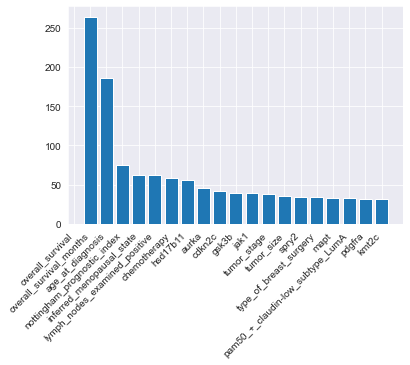

In [140]:
# c) Split the dataset into train and test sets 
X = df.drop(columns=['death_from_cancer', 'patient_id', 'oncotree_code'], axis = 1)
y = df['death_from_cancer']

X, y, fs = select_features(X, y, 20)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [141]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# convert the array back to a dataframe
X_train = DataFrame(X_train)
X_test = DataFrame(X_test)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1416, 20) (472, 20)
(1416,) (472,)


**<u>Findings:</u>**
Overall, the training and validation performances of this Keras Sequential model is in good agreement. However, the loss values over 50 epoches are very good (~0.01) meaning it is ready for prediction.

In [142]:
def model_builder(hp):
    model = keras.Sequential()
  

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(keras.layers.Dense(units=hp_units, input_shape = (20, ), activation = 'relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(1, activation='softplus'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_squared_logarithmic_error',
                metrics=['mse'])

    return model

In [143]:
tuner = kt.Hyperband(model_builder,
                     objective='mse',
                     max_epochs=50,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [144]:
tuner.search(X_train, y_train, epochs=50,batch_size=64)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 448 and the optimal learning rate for the optimizer
is 0.001.



In [145]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=50, validation_split=0.2)

val_acc_per_epoch = history.history['mse']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/50
36/36 [==============================] - 5s 53ms/step - loss: 0.1477 - mse: 0.5250 - val_loss: 0.0763 - val_mse: 0.3225
Epoch 2/50
36/36 [==============================] - 1s 17ms/step - loss: 0.0581 - mse: 0.2452 - val_loss: 0.0328 - val_mse: 0.1414
Epoch 3/50
36/36 [==============================] - 1s 15ms/step - loss: 0.0329 - mse: 0.1658 - val_loss: 0.0225 - val_mse: 0.1194
Epoch 4/50
36/36 [==============================] - 1s 22ms/step - loss: 0.0257 - mse: 0.1438 - val_loss: 0.0208 - val_mse: 0.1233
Epoch 5/50
36/36 [==============================] - 1s 20ms/step - loss: 0.0246 - mse: 0.1420 - val_loss: 0.0202 - val_mse: 0.1221
Epoch 6/50
36/36 [==============================] - 1s 15ms/step - loss: 0.0232 - mse: 0.1369 - val_loss: 0.0194 - val_mse: 0.1152
Epoch 7/50
36/36 [==============================] - 1s 14ms/step - loss: 0.0220 - mse: 0.1303 - val_loss: 0.0188 - val_mse: 0.1125
Epoch 8/50
36/36 [==============================] - 0s 14ms/step - loss: 0.0218 - m

In [146]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_fit=hypermodel.fit(X_train, y_train, epochs=best_epoch,validation_data=(X_test,y_test),batch_size=64)

Epoch 1/49
23/23 [==============================] - 3s 40ms/step - loss: 0.1690 - mse: 0.5978 - val_loss: 0.1059 - val_mse: 0.3780
Epoch 2/49
23/23 [==============================] - 0s 15ms/step - loss: 0.0773 - mse: 0.3022 - val_loss: 0.0511 - val_mse: 0.2079
Epoch 3/49
23/23 [==============================] - 0s 18ms/step - loss: 0.0432 - mse: 0.1950 - val_loss: 0.0328 - val_mse: 0.1593
Epoch 4/49
23/23 [==============================] - 0s 16ms/step - loss: 0.0314 - mse: 0.1611 - val_loss: 0.0277 - val_mse: 0.1368
Epoch 5/49
23/23 [==============================] - 0s 17ms/step - loss: 0.0275 - mse: 0.1514 - val_loss: 0.0229 - val_mse: 0.1257
Epoch 6/49
23/23 [==============================] - 0s 15ms/step - loss: 0.0263 - mse: 0.1499 - val_loss: 0.0217 - val_mse: 0.1268
Epoch 7/49
23/23 [==============================] - 0s 15ms/step - loss: 0.0234 - mse: 0.1348 - val_loss: 0.0216 - val_mse: 0.1205
Epoch 8/49
23/23 [==============================] - 0s 15ms/step - loss: 0.0233 - m

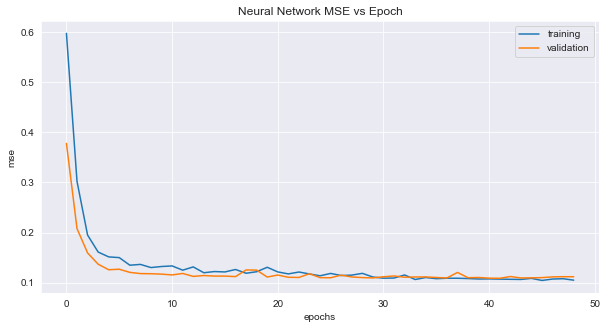

In [147]:
# Plot learning curve
plt.figure(figsize = (10, 5))
plt.plot(hypermodel_fit.history['mse'], label = 'training')
plt.plot(hypermodel_fit.history['val_mse'], label = 'validation')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('Neural Network MSE vs Epoch')
plt.legend()

In [148]:
predictions_hyper=(hypermodel.predict(X_test)).astype("int32")

15/15 [==============================] - 0s 4ms/step


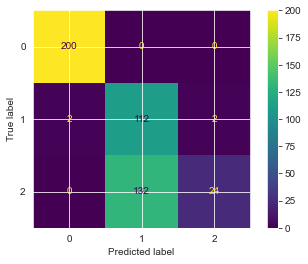

In [149]:
cm = confusion_matrix(y_test,predictions_hyper)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [150]:
print(accuracy_score(y_test, predictions_hyper))
print(classification_report(y_test, predictions_hyper))

0.711864406779661
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00       200
         1.0       0.46      0.97      0.62       116
         2.0       0.92      0.15      0.26       156

    accuracy                           0.71       472
   macro avg       0.79      0.71      0.63       472
weighted avg       0.84      0.71      0.66       472



## 6.3 Machine Learning Algorithms (DecisionTreeClassifier & Support Vector Classifier)


In [151]:
# Choose the parameters for the algorithms
num_folds = 20
seed = 8
scoring = 'accuracy'

# Choose ML algorithms to evaluate and append them inside a list
models = []
# Classification And Regression Tree
models.append(('CART', DecisionTreeClassifier()))
# Support Vector Machine
models.append(('SVM', SVC(gamma='auto')))

In [152]:
#Next, we compare all three of the algorithms.
finalResults = []
algorithmName = []

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    crossValScore = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    finalResults.append(crossValScore)
    algorithmName.append(name)
    output = "%s: %f (%f)" % (name, crossValScore.mean(), crossValScore.std())
    print(output)

CART: 0.786831 (0.050062)
SVM: 0.829839 (0.045396)


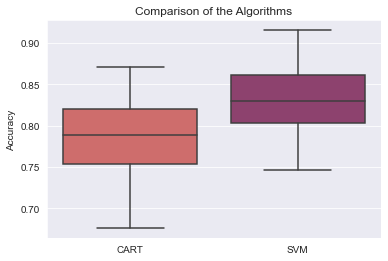

In [153]:
# Distribution of accuracy values calculated across 20 cross-validation folds.
ax = sns.boxplot(data=finalResults,palette="flare")
plt.title('Comparison of the Algorithms')
ax.set_xticklabels(algorithmName)
plt.ylabel('Accuracy')
plt.show()

**<u>Findings:</u>**
Generally, both of these algorithms, _CART (Classification And Regression Tree)_ and _SVC (Support Vector Classifier)_ have a decent training performance overall. However, the SVM model will be chosen for additional tuning because it had the highest average score (0.82). The additional tuning will be discussed in **_section 7.2_**.

# 7.0 Improve Performance
## 7.1 XGBoost Algorithm Tuning

In [154]:
# define model
model_XGB = XGBClassifier(use_label_encoder=False)

C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [155]:
# sensitivity parameters
# tuning learning rate and the number of trees
l_rate = [0.001, 0.01, 0.1]
n_tree = [100, 300, 500]
param_grid = dict(learning_rate = l_rate, n_estimators = n_tree)

# grid search on optimum hyperparameters for XGBoost model
model_XGB_temp = GridSearchCV(estimator=model_XGB, param_grid=param_grid,
                            scoring='neg_log_loss', verbose=1)

grid_result = model_XGB_temp.fit(X_train1, y_train1, eval_metric='rmse')
print('Optimum parameters %s' % (grid_result.best_params_))

C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310

C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310

C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310\lib\site-packages\xgboost\sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
C:\Python310

Optimum parameters {'learning_rate': 0.01, 'n_estimators': 500}


**<u>Findings:</u>**
Then, we will implement these optimum parameters to retrain and validate the dataset.

## 7.2 SVC Algorithm Tuning

#### 7.2.1 Hyperparameter Tuning using GridSearchCV

In [156]:
# Create the SVC model
svcModel = SVC(gamma='auto')

# Define the parameter grid
c_val = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_val = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_val, kernel=kernel_val)

# Perform GridSearchCV of the optimum model parameters
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Create the grid search object
grid_search = GridSearchCV(estimator=svcModel, param_grid=param_grid, scoring=scoring, cv=kfold)

# Fit the grid search to the data
grid_result = grid_search.fit(X_train, y_train)
print("Best parameters for SVC: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best parameters for SVC: 0.839738 using {'C': 0.5, 'kernel': 'linear'}


**<u>Findings</u>**:
We can see that the accuracy improved slightly by tuning model's parameters using GridSearchCSV. In addition to adjusting the model's parameters, we can test ensemble algorithms, which combine the predictions from various models to achieve better predictive performance.

#### 7.2.2 Using Ensemble Algorithms to improve performance

In [157]:
# Choose 2 ensemble algorithms
ensembleAlgo = []
ensembleAlgo.append(('GBM', GradientBoostingClassifier()))
ensembleAlgo.append(('RF', RandomForestClassifier(n_estimators=10)))

In [158]:
# Train and rank models using cross_val_score function
finalResults = []
algoNames = []
for name, model1 in ensembleAlgo:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    crossValScore2 = cross_val_score(model1, X_train, y_train, cv=kfold, scoring=scoring)
    finalResults.append(crossValScore2)
    algoNames.append(name)
    output = "%s: %f (%f)" % (name, crossValScore2.mean(), crossValScore2.std())
    print(output)

GBM: 0.836197 (0.053329)
RF: 0.816499 (0.049145)


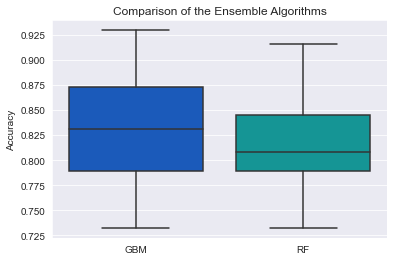

In [159]:
# Distribution of accuracy values calculated across 20 cross-validation folds.
ax = sns.boxplot(data=finalResults,palette="winter")
plt.title('Comparison of the Ensemble Algorithms')
ax.set_xticklabels(algoNames)
plt.ylabel('Accuracy')
plt.show()

**<u>Findings</u>**:
We can see that the both of the ensemble algorithms; GBM (Gradient Boosting Machine) and RF (Random Forest) achieved good results which is comparable with it Machine Learning algorithms counterparts. From both of the ensemble algorithms, GBM has achieved a good accuracy.


# 8.0 Finalize Model
## 8.1 Predictions on Validation Dataset

In [160]:
# define XGBoost model with optimum set of parameters
model_XGB = XGBClassifier(learning_rate=0.01,
                        n_estimators=500, use_label_encoder=False)

# fit the rained model to the validation data
fit_XGB = model_XGB.fit(X_train1, y_train1)

# estimate accuracy on validation dataset
fit_XGB.score(X_test1, y_test1)
pred = fit_XGB.predict(X_test1)

# print the accuracy score
accuracy_XGB = accuracy_score(y_test1, pred)
print("Accuracy for XGBoost Algorithm: %.2f%%" % (accuracy_XGB * 100.00))

C:\Python310\lib\site-packages\xgboost\sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Accuracy for XGBoost Algorithm: 83.25%


In [161]:
print(classification_report(y_test1, pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       250
         1.0       0.71      0.65      0.68       154
         2.0       0.69      0.75      0.72       163

    accuracy                           0.83       567
   macro avg       0.80      0.80      0.80       567
weighted avg       0.83      0.83      0.83       567



**<u>Findings:</u>**
The Tuning XGBoost model parameters lift the accuracy slightly from 80.60% to 81.66% but still within the range of standard Machine Learning algorithms.

### 8.1.1 Save XGBoost Model

In [162]:
# save the model to disk
filename = 'finalized_model_XGB.sav'
dump(model_XGB, open(filename, 'wb'))

## 8.2 GBM (Prediction on Validation Dataset)

#### Due to its low complexity and stable model, the Gradient Boosting Machine (GBM) was selected as the solution for this issue.


In [163]:
modelGBM = GradientBoostingClassifier()
modelGBM.fit(X_train, y_train)

# estimate the accuracy on the validation dataset
modelGBM.score(X_test, y_test)
y_pred1 = modelGBM.predict(X_test)

In [164]:
# Print the Accuracy score and classification report
print('Accuracy Score:' , accuracy_score(y_test, y_pred1))
print(classification_report(y_test, y_pred1))

Accuracy Score: 0.8114406779661016
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       200
         1.0       0.64      0.53      0.58       116
         2.0       0.69      0.78      0.73       156

    accuracy                           0.81       472
   macro avg       0.78      0.77      0.77       472
weighted avg       0.81      0.81      0.81       472



**<u>Findings:</u>**
We can see that the prediction accuracy is over 80% overall, which is regarded as a strong performance. The findings indicated that the "Living" feature (Class 0), which had the largest sample size, had a high F1-score. The opposite is true for "Died of Other Causes" (Class 1).

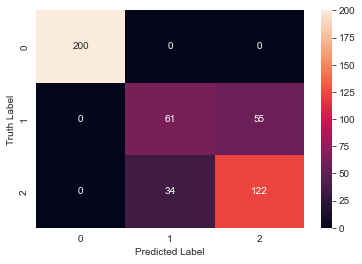

In [165]:
#Use seaborn visual to view the performance of the predictions in a confusion matrix 
confusionMatrixPlot = tf.math.confusion_matrix(labels = y_test, predictions = y_pred1)
sns.heatmap(confusionMatrixPlot, annot = True, fmt = 'd')
plt.xlabel ('Predicted Label')
plt.ylabel('Truth Label')
plt.show()

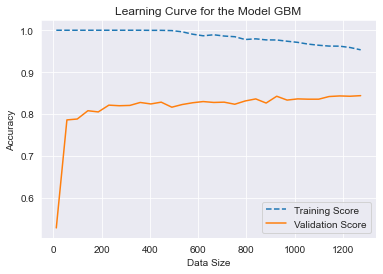

In [166]:
# The performance of the fit model using the learning curve
train_sizes, train_scores, test_scores = learning_curve(modelGBM, X_train, y_train, cv=10, train_sizes=np.linspace(0.01, 1.0, 30))

plt.plot(train_sizes,np.mean(train_scores, axis=1), '--',  label="Training Score")
plt.plot(train_sizes,np.mean(test_scores, axis=1), label="Validation Score")

plt.title("Learning Curve for the Model GBM")
plt.xlabel('Data Size') 
plt.ylabel('Accuracy') 
plt.legend(loc = "best")
plt.show()

**<u>Findings:</u>**
According to the learning curve, the model has achieved high accuracy and is prepared to predict data from new datasets.

### 8.2.1 Save Gradient Boosting Machine (GBM) Model

In [167]:
filename = 'finalModelGBM.sav'
dump(modelGBM, open(filename, 'wb'))

# 9.0 Conclusion
- We performed Exploratory Data Analysis and Cleaning before passing the data into algorithms for training and prediction.
- Exploratory Data Analysis and Data Cleaning are crucial steps in this complex dataset to ensure achieving good training and validation performance.

**XGBoost**
- The ensemble algorithm (XGBoost) with default parameters has a prediction accuracy of 81% which is within the range of Machine Learning and ensemble algorithms. Further tuning of the model's parameters (learning rate and tree number) improves its performance slightly to 82%.

**ML Algorithms (SVM and CART)**
- We compared two Machine Learning algorithms and two ensemble algorthms. We can see that out of the two ML algorithms, Support Vector Machine (SVM) achieved a higher accuracy (0.82) than Classification And Regression Tree (CART). Further tuning of the SVM's model parameters lifted the prediction accuracy slightly to 0.84. The next section will be talking about the two other ensemble algorithm.

**Ensemble Algorithms (RF and GBM)**
- Besides that, for the two ensemble algorithms, Gradient Boosting Machine (GBM) and RF (Random Forest) and we can see that they achieved comparable prediction accuracy compared to the Machine Learning algorithms.
- A similar score to the SVM was produced by the GradientBoostingClassifier (GBM).
- As a result, due to its simplicity and stability, we selected GBM as the final model out of the two ML algorithms and two ensemble algorithms.

**Conclusion**
- Predictive performances of all Machine Learning and Deep Learning algorithms on this dataset are very good with the accuracy over 80%.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=225e3e16-cbbc-48e0-b24b-cdac8310a3e6' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>